In [37]:
# import relevant packages
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import scipy
import csv
# %matplotlib qt


In [38]:
def distribute(needs,space): #distributes cars, there might be a faster way, but i cannot think of one right now
    endresult=np.zeros(len(needs),dtype=int)
    # filter=needs
    while space>=np.sum((needs>0)):
        add=min(np.min(needs[needs>0]),space//np.sum((needs>0)))
        endresult[needs>0]+=add
        space-=add*np.sum((needs>0))
        needs[needs>0]-=add
    endresult[np.nonzero(needs>0)[0][:space]]+=1
    return endresult
class edge(object):
    def __init__(self,length,lanes,id=0):
        self.length = int(length)
        self.lanes = int(lanes)
        self.cars = np.zeros((int(lanes*length/(4.5+55)),5)) 
        self.id=id
    def __str__(self): 
        return f"edge {self.id} cars:{np.sum(self.cars[:,0])}"
    def __repr__(self): 
        return f"edge {self.id} cars:{np.sum(self.cars[:,0])}"
    def C(self):
        return int(self.lanes*self.length/(4.5+55))
    def tto(self):
        return self.length/100*60/1000
    def update(self):
        Filter = np.nonzero(self.cars[:,0]==1)[0] #Filter for 
        self.cars[Filter,2] -= 1 #travelled one minute
        self.cars[Filter,1] += 1 #aged one minute
    def tt(self):
        return self.tto()*(1+0.15*(np.sum(self.cars[0])/self.C())**4)
    def size(self):
        return sum(self.cars[:,0])
class node(object):
    def __init__(self,input=[],output=[],destinations=[],id=0):
        self.id=id
        self.output = output
        self.input = input
        self.destinations=destinations
        self.waitlist=dict(zip(self.output,[dict(zip(self.input,[np.zeros(0,dtype=int) for j in self.input]))for i in self.output]))
        self.buildup=np.zeros((0,5))
        self.times=np.array([])
    def initwaitlist(self):
        if len(self.waitlist.keys())>0: print("waitlist already had keys",self.waitlist); return
        else: self.waitlist=dict(zip(self.output,[dict(zip(self.input,[np.zeros(0,dtype=int) for j in self.input]))for i in self.output]))
    def __str__(self): 
        if len(self.buildup): return f"node {self.id} with input: {[i.id for i in self.input]} and output: {[i.id for i in self.output]} and buildup:{len(self.buildup)}"
        else: return f"node {self.id} with input: {[i.id for i in self.input]} and output: {[i.id for i in self.output]}"
    def __repr__(self): 
        if len(self.buildup): return f"node {self.id} with input: {[i.id for i in self.input]} and output: {[i.id for i in self.output]} and buildup:{len(self.buildup)}"
        else: return f"node {self.id} with input: {[i.id for i in self.input]} and output: {[i.id for i in self.output]}"
    def size(self):
        return len(self.buildup)
    def flow(self):
        for i in self.input:
            Remove=np.nonzero(np.logical_and(i.cars[:,4]==self.id,np.logical_and(i.cars[:,2]<=0,i.cars[:,0]==1)))
            self.times=np.concatenate((self.times,i.cars[Remove,1].flatten())) #remove all cars that have arrived at their destination
            i.cars[Remove,:]=0
            if self.output==[]: continue
            Filter2 = np.nonzero(np.logical_and(i.cars[:,2]==0,i.cars[:,0]==1))[0] #check which cars arrived now
            p=np.ones(len(self.output))
            for index,edge in enumerate(self.output):
                if np.sum(edge.cars[:,0])==0: p[index]=1/edge.tto()
                else: p[index]=1/(np.sum(edge.cars[edge.cars[:,2]>0,2])/np.sum(edge.cars[:,0]))
            choices=np.random.choice(self.output,len(Filter2),p=p/np.sum(p)) ### can be replaced by larger function to better decide the choices
            for j in self.output:
                self.waitlist[j][i]=np.concatenate((self.waitlist[j][i],np.array(Filter2[choices==j],dtype=int))) #add new indexes along with their location at the end
        for i in self.output:
            if sum([len(self.waitlist[i][j]) for j in self.input])==0: continue #doesn't need to do anything if there are no cars waiting
            elif sum([len(self.waitlist[i][j]) for j in self.input])<=np.sum(i.cars[:,0]==0):
                for j in self.input:
                    filter=np.nonzero(i.cars[:,0]==0)[0][:len(self.waitlist[i][j])]
                    i.cars[filter]=j.cars[self.waitlist[i][j],:] #put cars in next edge
                    i.cars[filter,2]=np.ceil(i.tt()+np.random.normal(0,2,size=len(filter)))
                    j.cars[self.waitlist[i][j],:]=0 #empty the cars
                    self.waitlist[i][j]=np.zeros(0,dtype=int) #empty waitlist
            else:
                print(f"edge {i} is full",i.C())
                space=np.sum(i.cars[:,0]==0)
                needs=np.array([len(self.waitlist[i][j]) for j in self.input])
                allowances=distribute(needs,space)
                for k,j in enumerate(self.input):
                    filter=np.nonzero(i.cars[:,0]==0)[0][:allowances[k]]
                    i.cars[filter]=j.cars[self.waitlist[i][j][:allowances[k]]] ###probs dont need [filtertje,:] [filtertje] seems enough
                    i.cars[filter,2]=np.ceil(i.tt()+np.random.normal(0,2,size=len(filter)))
                    j.cars[self.waitlist[i][j][:allowances[k]],:]=0 #empty the cars
                    self.waitlist[i][j]=self.waitlist[i][j][allowances[k]:]
    def generate(self,state,mean=85,sd=1.5,destinations=[2]): ##change code to account for more generating cities and differing distributions
        N=int(np.random.normal(mean,sd))
        newcars=np.array([np.ones(N),np.zeros(N),np.random.normal(0,2,size=N),np.full(N,self.id),np.random.choice(range(len(self.output)),N)]).transpose()
        newcars=np.concatenate((self.buildup,newcars))
        self.buildup=np.zeros((0,5))
        for j,i in enumerate(self.output):
            going=newcars[:,4]==j
            filter = np.nonzero(i.cars[:,0]==0)[0]
            # print(np.sum(i.cars[:,0]==0),np.sum(going))
            if np.sum(i.cars[:,0]==0)>=np.sum(going): #can go if there are enough spaces for it
                # print("this case")
                i.cars[filter[:np.sum(going)],:]=newcars[going,:]
                i.cars[filter[:np.sum(going)],2]=np.ceil(i.tt()+i.cars[filter[:np.sum(going)],2])
                i.cars[filter[:np.sum(going)],4]=destinations[0]
                newcars=newcars[newcars[:,4]!=j]
            else: 
                spaces=np.sum(i.cars[:,0]==0)
                i.cars[filter,:]=newcars[np.nonzero(going==1)[0][:spaces],:]
                i.cars[filter,2]=np.ceil(i.tt()+i.cars[filter,2])
                i.cars[filter,4]=destinations[0]
                self.buildup=np.concatenate((self.buildup,newcars[np.nonzero(going==1)[0][spaces:]])) #throw all excess cars into the buildup

In [39]:
# e_23 = edge(60000,2,id=23) 
# e_13 = edge(40000,2,id=13)
# e_a1 = edge(30000,2,id=1)
# e_a2 = edge(50000,2,id=2)
# n_a = node(output=[e_a1,e_a2],id=4)
# n_1 = node(input=[e_a1],output=[e_13],id=1)
# n_2 = node(input=[e_a2],output=[e_23],id=2)
# n_3 = node(input=[e_13,e_23],id=3)

# for minute in range(240):
#     n_a.generate("")
#     e_a1.update()
#     e_a2.update()
#     e_13.update()
#     e_23.update()
#     n_1.flow()
#     n_2.flow()
#     n_3.flow()

In [40]:
#importing the map
traffic_map = gpd.read_file("./map/2city_shape_v5.shp").to_crs(epsg=4326)
traffic_map['geometry'] = traffic_map['geometry'].scale(xfact= 1/100,yfact =1/100, origin = (0,0))

#capacity
traffic_map['capciteit'] = traffic_map['lengte']*traffic_map['banen']*1/(4.5+55)

# splitting_tabels

Node_df = pd.concat((traffic_map[traffic_map['Category'] == 'City'].iloc[:,:], traffic_map[traffic_map['Category'] == 'Node'].iloc[:,:])) 
Edge_df = traffic_map[traffic_map['Category'] == 'Edge'].iloc[:,:]

#printing the tables
print(traffic_map)
#print(Node_df)
#print(Edge_df)

    id     name   lengte  maxshd  banen Category  \
0    1    City1      NaN     NaN    NaN     City   
1    2    City2      NaN     NaN    NaN     City   
2    3   Node_A      NaN     NaN    NaN     Node   
3    4   Node_B      NaN     NaN    NaN     Node   
4    5   Node_C      NaN     NaN    NaN     Node   
5    6   Node_D      NaN     NaN    NaN     Node   
6    7   Node_E      NaN     NaN    NaN     Node   
7    8  Edge_1A  30000.0   100.0    2.0     Edge   
8    9  Edge_1B  50000.0   100.0    2.0     Edge   
9   10  Edge_AC  40000.0   100.0    2.0     Edge   
10  11  Edge_BC  60000.0   100.0    2.0     Edge   
11  12  Edge_CD  20000.0   100.0    2.0     Edge   
12  13  Edge_D2  10000.0   100.0    2.0     Edge   
13  14  Edge_C2  20000.0   100.0    1.0     Edge   
14  15  Edge_CE  30000.0   100.0    2.0     Edge   
15  16  Edge_E2   5000.0   100.0    2.0     Edge   

                                             geometry    capciteit  
0   POLYGON ((0.66646 -3.58556, 0.81725 -3.338

In [41]:
#making nodes and edges
nodedict=dict(zip(Node_df['id'],[node([],[],id=i) for i in Node_df['id']]))
edgedict=dict(zip(Node_df['id'],[dict() for i in Node_df['id']]))

for i in Edge_df["id"]:

    start,end=list(str(np.array(Edge_df['name'].loc[Edge_df['id']==i]))[-4:-2])
    for j in Node_df["name"]:
        if start in j: startid=str(np.array(Node_df['id'].loc[Node_df['name']==j])[0])
        if end in j: endid=str(np.array(Node_df['id'].loc[Node_df['name']==j])[0])
    edgedict[int(startid)][int(endid)]=edge(Edge_df['lengte'][i-1],Edge_df['banen'][i-1],id=i)

for i in nodedict.keys():
    nodedict[i].output=[edgedict[i][j]for j in edgedict[i].keys()]
    for j in edgedict[i].keys():
        nodedict[j].input.append(edgedict[i][j])
for i in range(7):
    nodedict[i+1].initwaitlist()
    # print(nodedict[i+1].input)

In [42]:
minutes = 240
tf_df = traffic_map.copy()
cars=np.zeros((len(tf_df["id"]),minutes))

for minute in range(minutes):
    print(minute)
    nodedict[1].generate('')
    for j in list(nodedict.keys())[:]:
        nodedict[j].flow()
    for j in edgedict.keys():
        for k in edgedict[j].keys(): 
            edgedict[j][k].update()
    for i in nodedict:
        cars[int(i)-1,minute]=nodedict[i].size()
    pass
    for i in Edge_df["id"]:
        start,end=list(str((Edge_df['name'][i-1]))[-2:])
        for index,j in enumerate(Node_df["name"]):
            if start in j: startid=(Node_df['id'][index])
            if end in j: endid=(Node_df['id'][index])
        cars[int(i)-1,minute]=np.sum(edgedict[int(startid)][int(endid)].cars[:,0])

#making a nice dataframe    
cars_time_df = pd.DataFrame(cars)


tf_df = pd.concat((tf_df,cars_time_df),axis = 1)
# print(tf_df)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
edge edge 14 cars:314.0 is full 336
77
edge edge 14 cars:313.0 is full 336
78
edge edge 14 cars:314.0 is full 336
79
edge edge 14 cars:313.0 is full 336
80
edge edge 14 cars:313.0 is full 336
81
edge edge 14 cars:304.0 is full 336
82
edge edge 14 cars:314.0 is full 336
83
edge edge 14 cars:311.0 is full 336
84
edge edge 14 cars:308.0 is full 336
85
edge edge 14 cars:303.0 is full 336
86
edge edge 14 cars:305.0 is full 336
87
edge edge 14 cars:310.0 is full 336
88
edge edge 14 cars:306.0 is full 336
89
edge edge 14 cars:312.0 is full 336
90
edge edge 14 cars:308.0 is full 336
91
edge edge 14 cars:320.0 is full 336
92
edge edge 14 cars:303.0 is full 336
93
edge edge 14 cars:316.0 is full 336
94
edge edge 14 cars:307.0 is full 336
95
edge edge 14 cars:302.0 is full 336
96

### Statistics

In [143]:
save_plots = True

In [131]:
def pdf_bimodal(x, mu1, sd1, mu2, sd2, weight2):
    # normpdf(mu1, sd1) + weight2 * normpdf(mu1, sd1)
    # normalization constant 1+weight2
    return 1/(1+weight2) * (scipy.stats.norm.pdf(x, mu1, sd1) + weight2*scipy.stats.norm.pdf(x, mu2, sd2))

def qbimodal(p, cdf, centers): # cdf is array of values for the CDF
    diff_abs = np.abs(cdf - p)
    return centers[np.argmin(diff_abs)]

# create class for probplot
class Bimodal:
    def ppf(p):
        return np.array([qbimodal(p_v, cdf_param, centers) for p_v in p])

bin_count=62


C:\Users\Alexander\AppData\Local\Temp\ipykernel_14488\2183010364.py:34: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


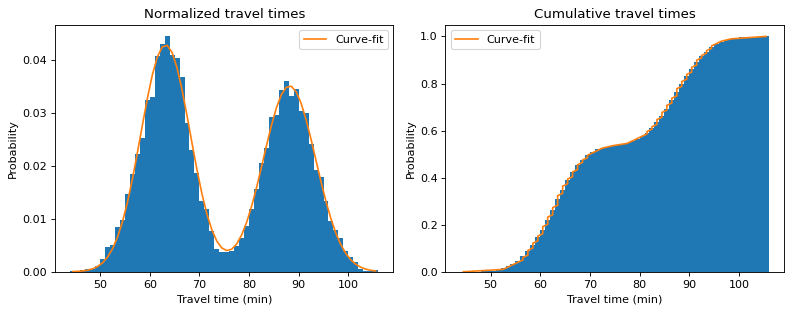

In [155]:
n_b = nodedict[2]
bin_count = int((max(n_b.times)-min(n_b.times)))
print(f"{bin_count=}")

# create subplots of pdf and cdf
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), dpi=80)

# pdf hist
pdf, bins, _ = ax1.hist(n_b.times, bins=bin_count, density=True)
centers = (bins[:-1] + bins[1:])/2
popt, pcov = scipy.optimize.curve_fit(pdf_bimodal, centers, pdf, p0=[65, 1, 88, 1, 0.8])
ax1.plot(centers, pdf_bimodal(centers, *popt), label='Curve-fit')

# cdf hist
edf, bins, _ = ax2.hist(n_b.times,bins=bin_count, density=True, cumulative=True)
# centers = (bins[:-1] + bins[1:])/2
cdf_param = np.cumsum(pdf_bimodal(centers, *popt))
# ax2.plot(centers, cdf_param)
ppoints = np.linspace(0.00, 1, num=100)
ax2.plot(Bimodal.ppf(ppoints), ppoints, label='Curve-fit')

# axis labels, titles
ax1.set_title("Normalized travel times")
ax1.set_ylabel("Probability")
ax1.set_xlabel("Travel time (min)")
ax1.legend()

ax2.set_title("Cumulative travel times")
ax2.set_ylabel("Probability")
ax2.set_xlabel("Travel time (min)")
ax2.legend()

f.tight_layout()
f.show()
if save_plots:
    f.savefig('./images/hist_traveltimes.png', dpi=400)

In [160]:
# mu1, sigma1, mu2, sigma2, weight
print(popt)
5.26762996**2

[63.18059567  4.99444876 88.15226594  5.26762996  0.86418187]


27.7479253954896

In [158]:
Dn = np.max(np.abs(edf - cdf_param))
print(f"{Dn=}")
# with alpha=0.05,
size = len(edf)
Dna = 1.35810/np.sqrt(size)
print(f"{size=}")
print(f"{Dna=}")
# plt.plot(centers, np.abs(edf - cdf_param))
# plt.show()

Dn=0.008541672757420044
size=62
Dna=0.17247887247895874


In [157]:
kstest = scipy.stats.kstest(edf, cdf_param)
# kstest.pvalue # big pvalue: acceptable distribution
kstest

KstestResult(statistic=0.016129032258064516, pvalue=0.9999999999999999, statistic_location=0.5548467517231266, statistic_sign=1)

#### Quantile from pdf_bimodal

len(data)=13638
slope=1.008425550701488
intercept=-0.7214303373495312


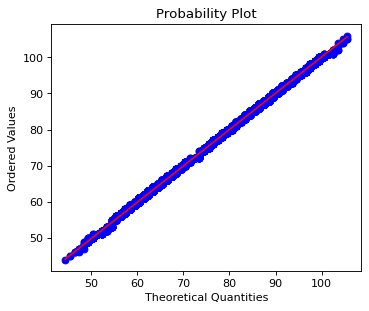

In [156]:

data = np.array(n_b.times, dtype=float)
print(f"{len(data)=}")
    
osm, osr = scipy.stats.probplot(data, dist=Bimodal, fit=False)
osm = np.asarray(osm)
slope, intercept, r, prob, _ = scipy.stats.linregress(osm, osr)

plt.figure(figsize=(5, 4), dpi=80)

plt.plot(osm, osr, 'bo')
plt.plot(osm, slope*osm + intercept, 'r-')
print(f"{slope=}")
print(f"{intercept=}")

plt.xlabel("Theoretical Quantities")
plt.ylabel("Ordered Values")
plt.title("Probability Plot")

if save_plots:
    plt.savefig('./images/qqplot.png', dpi=400)

plt.show()


**Plotting**

In [22]:
#plotting df

print(tf_df)



Plot_Node_df = pd.concat((tf_df[tf_df['Category'] == 'City'].iloc[:,:], tf_df[tf_df['Category'] == 'Node'].iloc[:,:])) 
Plot_Edge_df = tf_df[tf_df['Category'] == 'Edge'].iloc[:,:]
print(Plot_Node_df[100])

    id     name   lengte  maxshd  banen Category  \
0    1    City1      NaN     NaN    NaN     City   
1    2    City2      NaN     NaN    NaN     City   
2    3   Node_A      NaN     NaN    NaN     Node   
3    4   Node_B      NaN     NaN    NaN     Node   
4    5   Node_C      NaN     NaN    NaN     Node   
5    6   Node_D      NaN     NaN    NaN     Node   
6    7   Node_E      NaN     NaN    NaN     Node   
7    8  Edge_1A  30000.0   100.0    2.0     Edge   
8    9  Edge_1B  50000.0   100.0    2.0     Edge   
9   10  Edge_AC  40000.0   100.0    2.0     Edge   
10  11  Edge_BC  60000.0   100.0    2.0     Edge   
11  12  Edge_CD  20000.0   100.0    2.0     Edge   
12  13  Edge_D2  10000.0   100.0    2.0     Edge   
13  14  Edge_C2  20000.0   100.0    1.0     Edge   
14  15  Edge_CE  30000.0   100.0    2.0     Edge   
15  16  Edge_E2   5000.0   100.0    2.0     Edge   

                                             geometry    capciteit     0  \
0   POLYGON ((0.66646 -3.58556, 0.81725

In [23]:
#adding vehicles
data1= cars.copy()

cars_list = data1[:,0]


traffic_map.insert(3, "cars", cars_list, True)

#adding textprompts:




def gen_text(string):
    row_index = traffic_map.index[traffic_map['name'] == string]
    if "City" in string:
        return "City " + string[-1]
    elif 'Node' in string:
        if row_index!=None:
            num_of_car = traffic_map.loc[row_index[0], 'cars']
            return '\n' + string[-1] + f'\n cars: {num_of_car}'
        else:
            return '\n' + string[-1] + '\n cars: Not found'
    elif 'Edge' in string:
        if row_index!=None:
            num_of_car = traffic_map.loc[row_index[0], 'cars']
            return f'cars: {num_of_car}'
        else:
            return 'cars: Not found'
    else:
        return ''


traffic_map['textpromt'] = traffic_map['name'].apply(gen_text)




print(traffic_map)

    id     name   lengte  cars  maxshd  banen Category  \
0    1    City1      NaN   0.0     NaN    NaN     City   
1    2    City2      NaN   0.0     NaN    NaN     City   
2    3   Node_A      NaN   0.0     NaN    NaN     Node   
3    4   Node_B      NaN   0.0     NaN    NaN     Node   
4    5   Node_C      NaN   0.0     NaN    NaN     Node   
5    6   Node_D      NaN   0.0     NaN    NaN     Node   
6    7   Node_E      NaN   0.0     NaN    NaN     Node   
7    8  Edge_1A  30000.0  46.0   100.0    2.0     Edge   
8    9  Edge_1B  50000.0  39.0   100.0    2.0     Edge   
9   10  Edge_AC  40000.0   0.0   100.0    2.0     Edge   
10  11  Edge_BC  60000.0   0.0   100.0    2.0     Edge   
11  12  Edge_CD  20000.0   0.0   100.0    2.0     Edge   
12  13  Edge_D2  10000.0   0.0   100.0    2.0     Edge   
13  14  Edge_C2  20000.0   0.0   100.0    1.0     Edge   
14  15  Edge_CE  30000.0   0.0   100.0    2.0     Edge   
15  16  Edge_E2   5000.0   0.0   100.0    2.0     Edge   

             

C:\Users\Alexander\AppData\Local\Temp\ipykernel_14488\4213239350.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds', 120)
C:\Users\Alexander\AppData\Local\Temp\ipykernel_14488\4213239350.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap2 = plt.cm.get_cmap('Greens', 120)
C:\Users\Alexander\AppData\Local\Temp\ipykernel_14488\4213239350.py:20: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `

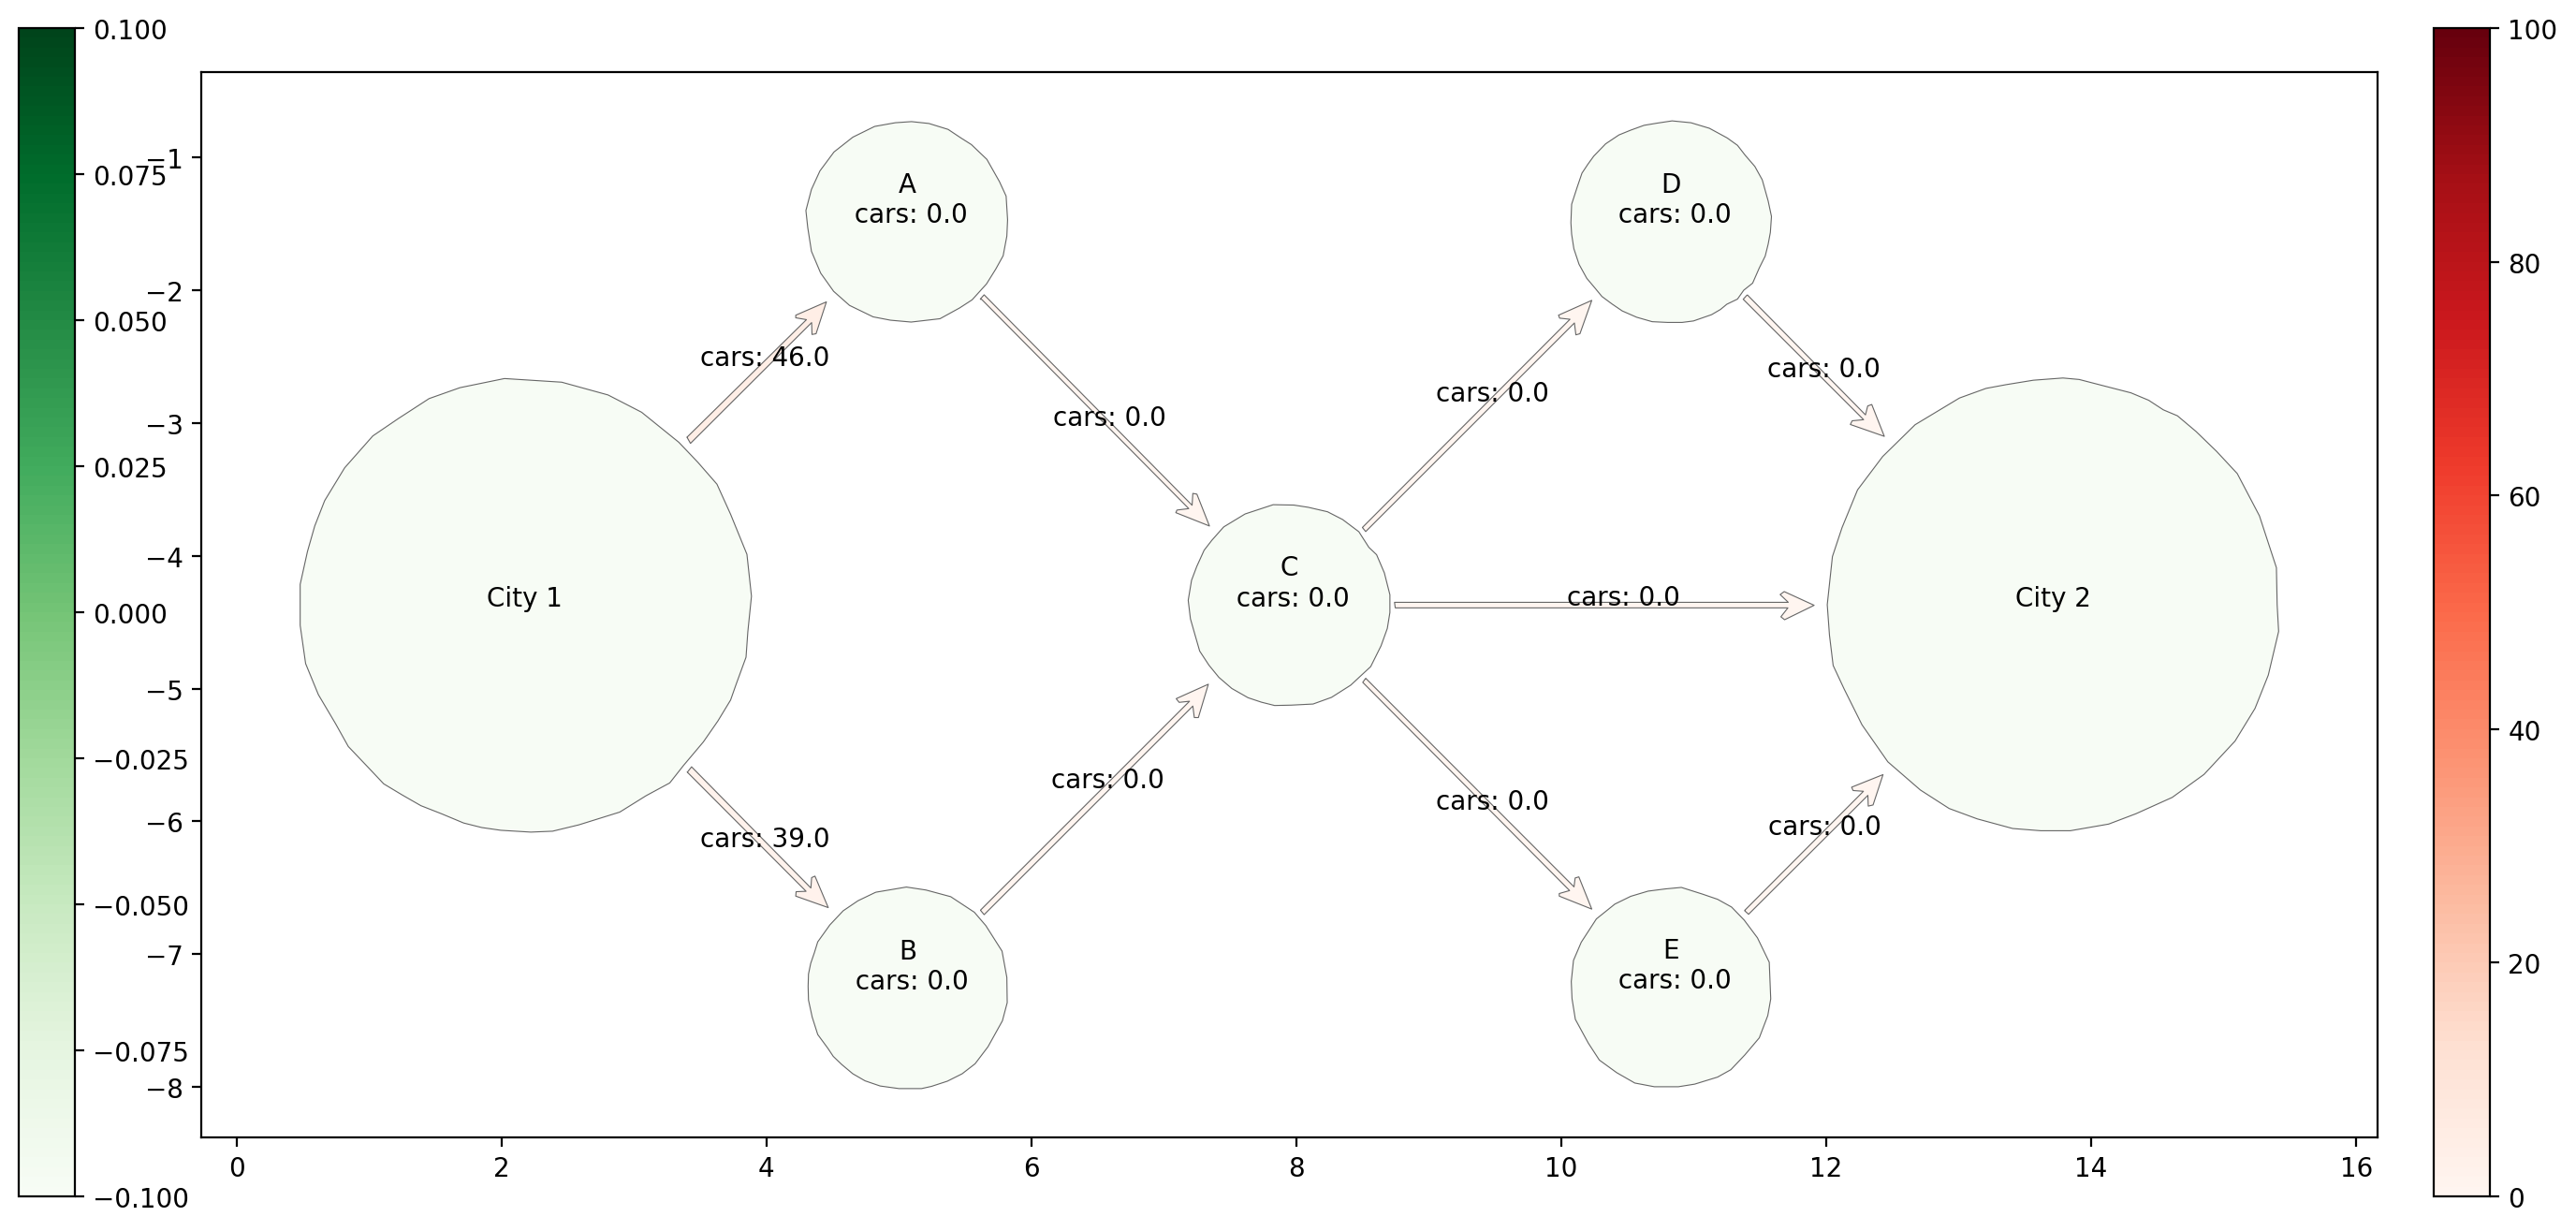

In [24]:
fig, ax = plt.subplots(1, figsize=(15, 8),dpi = 200)
cmap = plt.cm.get_cmap('Reds', 120)
cmap2 = plt.cm.get_cmap('Greens', 120)
print(cmap)
#cax = fig.add_axes([0.92, 0.1, 0.02, 0.78])  # Adjust the position and size as needed
data1[1] = 0
cax2 = fig.add_axes([0.06, 0.1, 0.02, 0.78])  # Adjust the position and size as needed
def update(i):
    ax.clear()
    traffic_map["cars"] = data1[:,i]
    traffic_map['textpromt'] = traffic_map['name'].apply(gen_text)
    Plot_Node_df.plot(column=i, cmap=cmap2, linewidth=0.4, ax=ax, edgecolor=".4",vmin=0,vmax=np.ceil(Plot_Node_df[i].max()/100)*100) ###hier moest er ook nog afgerond worden
    #plotting edges colored by fractions of capacity
    Plot_Edge_df.plot(column=Plot_Edge_df[i]/Plot_Edge_df["capciteit"], cmap=cmap, linewidth=0.4, ax=ax, edgecolor=".4",vmin=0,vmax=1)
    bar_info2 = plt.cm.ScalarMappable(cmap=cmap2, norm=plt.Normalize(vmin=0, vmax=np.ceil(Plot_Node_df[i].max()/100)*100))
    cbar = fig.colorbar(bar_info2, cax=cax2)
    
    #creating labels
    traffic_map.apply(lambda x: ax.annotate(text=x['textpromt'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)
anim = FuncAnimation(fig,update,interval = 100)

# Create a colorbar
cax = fig.add_axes([0.92, 0.1, 0.02, 0.78])  # Adjust the position and size as needed
bar_info = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=100))
bar_info._A = [] ### geen idee wat dit doet
cbar = fig.colorbar(bar_info, cax=cax)

